In [1]:
import pandas as pd

export_combined_data_path = "./combined.csv"

data_result_0_path = "C:/Dev/picoVideo/vrtv/SavedTrainingDataset/20230813_merged/0/20230816_8_8_0_0.csv"
data_result_1_path = "C:/Dev/picoVideo/vrtv/SavedTrainingDataset/20230813_merged/1/20230816_8_8_0_1.csv"
data_result_2_path = "C:/Dev/picoVideo/vrtv/SavedTrainingDataset/20230813_merged/2/20230816_8_8_0_2.csv"

# Read data
data_result_0 = pd.read_csv(data_result_0_path, header=None)
data_result_1 = pd.read_csv(data_result_1_path, header=None)
data_result_2 = pd.read_csv(data_result_2_path, header=None)

print(f"data result 0 cnt: {len(data_result_0)}")
print(f"data result 1 cnt: {len(data_result_1)}")
print(f"data result 2 cnt: {len(data_result_2)}")

print(data_result_1.iloc[0:2, :])

data_cnt_per_result = len(data_result_0)
data_result_1 = data_result_1.sample((int)(data_cnt_per_result / 2))
data_result_2 = data_result_2.sample((int)(data_cnt_per_result / 2))

data_all_result = pd.concat([data_result_0, data_result_1, data_result_2], axis=0)
print(f"data with all result cnt: {len(data_all_result)}")

# result为1、2都改为1
data_all_result.loc[data_all_result[68] > 0, 68] = 1

data_all_result.to_csv(export_combined_data_path, header=None, index=None, encoding="utf-8")


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Dev/picoVideo/vrtv/SavedTrainingDataset/20230813_merged/0/20230816_8_8_0_0.csv'

In [5]:
from sklearn.preprocessing import LabelEncoder
import torch

# Read data
data = pd.read_csv(export_combined_data_path, header=None)

print(data.iloc[0:2, :])
X = data.iloc[:, 0:68]
y = data.iloc[:, 68]
print(X.iloc[0:2, :])
print(y)

encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

# Convert to 2D PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

   0   1   2   3   4   5   6   7   8   9   ...  59  60  61  62  63  64  65  \
0   8   8   5   7   0   0   2  -1  -1  -1  ...   0   0   0   1  -1  -1  -1   
1   8   8   7   3  -1   1   0   0   0   0  ...   0   1  -1   1   0   0   0   

   66  67  68  
0   1   0   0  
1   0   0   0  

[2 rows x 69 columns]
   0   1   2   3   4   5   6   7   8   9   ...  58  59  60  61  62  63  64  \
0   8   8   5   7   0   0   2  -1  -1  -1  ...   1   0   0   0   1  -1  -1   
1   8   8   7   3  -1   1   0   0   0   0  ...   0   0   1  -1   1   0   0   

   65  66  67  
0  -1   1   0  
1   0   0   0  

[2 rows x 68 columns]
0      0
1      0
2      0
3      0
4      0
      ..
723    1
724    1
725    1
726    1
727    1
Name: 68, Length: 728, dtype: int64


In [6]:
import torch.nn as nn

# Define two models
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(68, 68*3)
        self.relu = nn.ReLU()
        self.output = nn.Linear(68*3, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(68, 68)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(68, 68)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(68, 68)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(68, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
model1 = Wide()
model2 = Deep()
print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))  # 11161
print(sum([x.reshape(-1).shape[0] for x in model2.parameters()]))  # 11041

14281
14145


In [22]:
import torch.optim as optim
import tqdm
import copy
import numpy as np

# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    # loss_fn = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 300   # number of epochs to run
    batch_size = 50  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    loss_values = []
    accuracy_values = []
    predict_acc_values = []

    for epoch in range(n_epochs):
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
                running_loss = float(loss)
                running_acc = float(acc)
        loss_values.append(running_loss)
        accuracy_values.append(running_acc)

        # for start in range(0, len(X_train), batch_size):
        #     X_batch = X_train[start:start+batch_size]
        #     y_batch = y_train[start:start+batch_size]
        #     # forward pass
        #     y_pred = model(X_batch)
        #     loss = loss_fn(y_pred, y_batch)
        #     # backward pass
        #     optimizer.zero_grad()
        #     loss.backward()
        #     # update weights
        #     optimizer.step()

        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        # loss = loss_fn(y_pred, y_val)
        # running_loss += loss.item()
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        predict_acc_values.append(acc)
        # loss_values.append(loss.item())
        # accuracy_values.append(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy

    # print("loss_values:")
    # print(loss_values)
    # print("accuracy_values:")
    # print(accuracy_values)
    model.load_state_dict(best_weights)


    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss', color=color)
    ax1.plot(loss_values, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('acc', color=color)  # we already handled the x-label with ax1
    ax2.plot(accuracy_values, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    ax3 = ax2.twinx()
    ax3 = ax2.twiny()
    color = 'tab:green'
    ax3.plot(predict_acc_values, color=color)
    # ax3.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('accuracy and loss')
    # plt.legend()
    plt.show()

    return best_acc

In [13]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

loss_values:
[0.708087682723999, 0.7001901268959045, 0.6950822472572327, 0.6914868354797363, 0.6886431574821472, 0.686238169670105, 0.6841301918029785, 0.6822624206542969, 0.6806288361549377, 0.6791821718215942, 0.6779008507728577, 0.676764190196991, 0.6757587194442749, 0.6748304963111877, 0.6739552617073059, 0.673153817653656, 0.6724314093589783, 0.6717676520347595, 0.6711441278457642, 0.6705780625343323, 0.6700371503829956, 0.6695525050163269, 0.6690881848335266, 0.6686338782310486, 0.6682283282279968, 0.6678546071052551, 0.6674943566322327, 0.6671653389930725, 0.6668440103530884, 0.6665217280387878, 0.6662037968635559, 0.665900707244873, 0.6656159162521362, 0.6653356552124023, 0.6650779843330383, 0.6648627519607544, 0.6646405458450317, 0.6644384860992432, 0.6642456650733948, 0.664090096950531, 0.6639456152915955, 0.6637797355651855, 0.6636210680007935, 0.6634594798088074, 0.6633210182189941, 0.6631817817687988, 0.6630641222000122, 0.6629506945610046, 0.6628420352935791, 0.6627522706

Epoch 299: 100%|██████████| 11/11 [00:00<00:00, 670.69batch/s, acc=1, loss=0.000895]


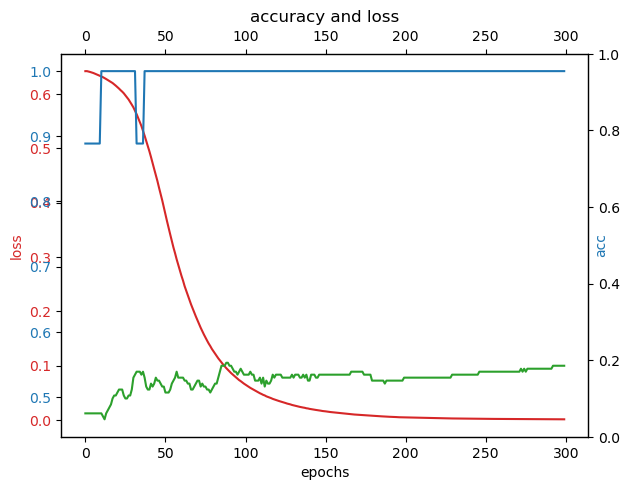

Final model accuracy: 55.25%


In [23]:
from sklearn.model_selection import StratifiedKFold, train_test_split
model = Deep()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

loss_values:
[0.6865220665931702, 0.6854918003082275, 0.6843019127845764, 0.6827046275138855, 0.6812120079994202, 0.6796592473983765, 0.678203821182251, 0.6768783926963806, 0.675304651260376, 0.673668622970581, 0.6718032360076904, 0.6697666645050049, 0.6676228046417236, 0.665079653263092, 0.6625111103057861, 0.6596512198448181, 0.6564366817474365, 0.653026282787323, 0.6490144729614258, 0.6441674828529358, 0.638785719871521, 0.632578432559967, 0.6257525086402893, 0.6178866028785706, 0.6086519360542297, 0.5990703701972961, 0.5888069868087769, 0.577986478805542, 0.566563606262207, 0.554133951663971, 0.5416176319122314, 0.5285241007804871, 0.5155733227729797, 0.5022299289703369, 0.4886074662208557, 0.4750462770462036, 0.4606756567955017, 0.4465772807598114, 0.4312262535095215, 0.41585004329681396, 0.4007829427719116, 0.3856198191642761, 0.37089723348617554, 0.35684242844581604, 0.3430085778236389, 0.3291509449481964, 0.3155665397644043, 0.3018709421157837, 0.28866448998451233, 0.2759678661

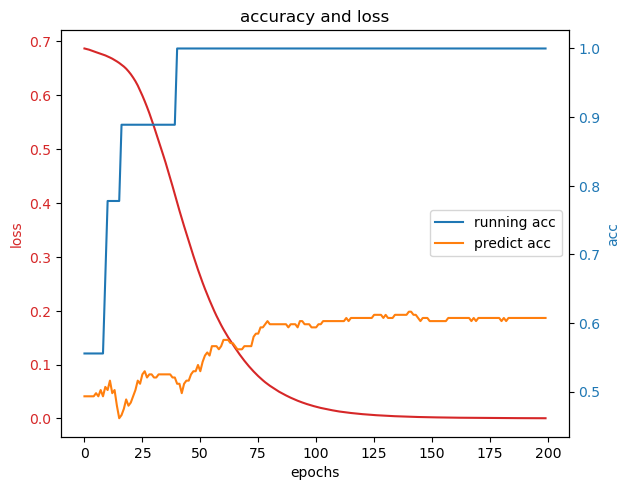

Final model accuracy: 61.64%


In [38]:
model = Deep()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

X_train, y_train, X_val, y_val = X_train, y_train, X_test, y_test
# loss function and optimizer
loss_fn = nn.BCELoss()  # binary cross entropy
# loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 200   # number of epochs to run
batch_size = 50  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_acc = - np.inf   # init to negative infinity
best_weights = None

loss_values = []
accuracy_values = []
predict_acc_values = []

for epoch in range(n_epochs):
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            acc = (y_pred.round() == y_batch).float().mean()
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
            running_loss = float(loss)
            running_acc = float(acc)
    loss_values.append(running_loss)
    accuracy_values.append(running_acc)

    # for start in range(0, len(X_train), batch_size):
    #     X_batch = X_train[start:start+batch_size]
    #     y_batch = y_train[start:start+batch_size]
    #     # forward pass
    #     y_pred = model(X_batch)
    #     loss = loss_fn(y_pred, y_batch)
    #     # backward pass
    #     optimizer.zero_grad()
    #     loss.backward()
    #     # update weights
    #     optimizer.step()

    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_val)
    # loss = loss_fn(y_pred, y_val)
    # running_loss += loss.item()
    acc = (y_pred.round() == y_val).float().mean()
    acc = float(acc)
    predict_acc_values.append(acc)
    # loss_values.append(loss.item())
    # accuracy_values.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
# restore model and return best accuracy

model.load_state_dict(best_weights)
print("loss_values:")
print(loss_values)
print("accuracy_values:")
print(accuracy_values)
print("predict_acc_values:")
print(predict_acc_values)


import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color=color)
ax1.plot(loss_values, color=color, label='loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('acc', color=color)  # we already handled the x-label with ax1
ax2.plot(accuracy_values, color=color, label='running acc')
ax2.plot(predict_acc_values, color='tab:orange', label='predict acc')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('accuracy and loss')
plt.legend(loc="center right")
plt.show()

print(f"Final model accuracy: {best_acc*100:.2f}%")